# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 20 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')
campvectrain = np.transpose(campvectrain, (0,2,3,1))

In [6]:
np.shape(campvectrain)

(7000, 20, 20, 2)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')
campvectest = np.transpose(campvectest, (0,2,3,1))

In [10]:
np.shape(campvectest)

(1000, 20, 20, 2)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')
campvecval = np.transpose(campvecval, (0,2,3,1))

In [14]:
np.shape(campvecval)

(2000, 20, 20, 2)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(20, 20, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(20, 20, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 128)               7

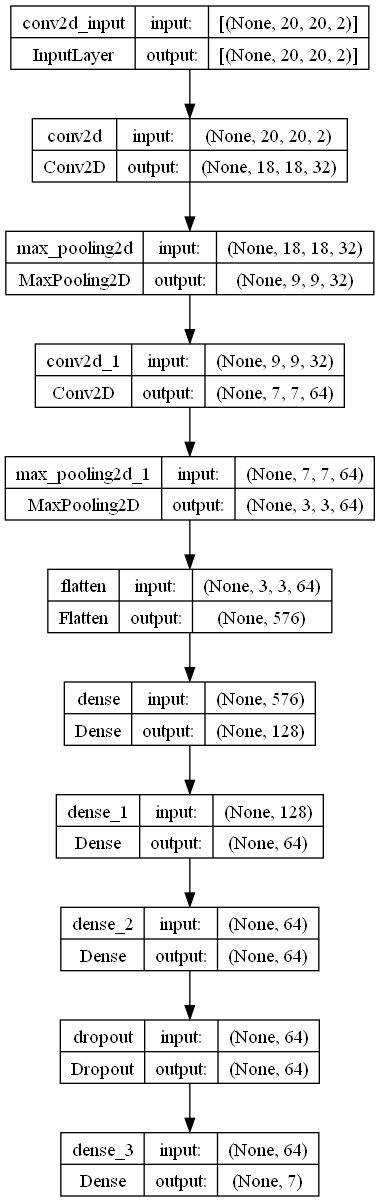

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [26]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def desviacion_total(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    return total_loss

metrics = [mse_component(i) for i in range(7)] + [desviacion_total]


In [28]:
model.compile(optimizer=optimizer,
              loss= 'mae',
              metrics=metrics)

In [29]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [30]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 2s 3ms/step - loss: 5.0153 - a_1: 2.7762 - a_2: 2.7378 - b_1: 2.1367 - b_2: 2.0780 - d_1: 1.4689 - d_2: 1.5097 - n: 1.5846 - desviacion_total: 14.2920 - val_loss: 2.9841 - val_a_1: 2.6232 - val_a_2: 2.0907 - val_b_1: 1.5103 - val_b_2: 1.4200 - val_d_1: 1.0216 - val_d_2: 1.1115 - val_n: 1.1874 - val_desviacion_total: 10.9648 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 2s 2ms/step - loss: 2.7138 - a_1: 2.3914 - a_2: 2.0292 - b_1: 1.6845 - b_2: 1.6289 - d_1: 1.2822 - d_2: 1.2796 - n: 1.2696 - desviacion_total: 11.5654 - val_loss: 2.1605 - val_a_1: 1.9203 - val_a_2: 1.6682 - val_b_1: 1.4010 - val_b_2: 1.2755 - val_d_1: 1.1020 - val_d_2: 0.8694 - val_n: 1.0787 - val_desviacion_total: 9.3152 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 2s 2ms/step - loss: 2.2095 - a_1: 2.0116 - a_2: 1.8638 - b_1: 1.4953 - b_2: 1.5086 - d_1: 1.1817 - d_2: 1.1760 - n: 1.1670 - desviacion_total: 10.4041 - va

Epoch 22/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.3857 - a_1: 1.4790 - a_2: 1.4636 - b_1: 1.0640 - b_2: 1.1126 - d_1: 0.8390 - d_2: 0.8182 - n: 0.9768 - desviacion_total: 7.7534 - val_loss: 1.0378 - val_a_1: 1.1852 - val_a_2: 1.1081 - val_b_1: 0.9274 - val_b_2: 0.7038 - val_d_1: 0.3105 - val_d_2: 0.3816 - val_n: 0.7866 - val_desviacion_total: 5.4032 - lr: 0.0010
Epoch 23/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.3725 - a_1: 1.4705 - a_2: 1.4673 - b_1: 1.0696 - b_2: 1.1033 - d_1: 0.8448 - d_2: 0.7990 - n: 0.9165 - desviacion_total: 7.6710 - val_loss: 1.1323 - val_a_1: 1.3050 - val_a_2: 1.3260 - val_b_1: 0.7443 - val_b_2: 0.8656 - val_d_1: 0.3699 - val_d_2: 0.5888 - val_n: 0.7049 - val_desviacion_total: 5.9045 - lr: 0.0010
Epoch 24/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.3589 - a_1: 1.4714 - a_2: 1.4602 - b_1: 1.0620 - b_2: 1.0916 - d_1: 0.8392 - d_2: 0.7996 - n: 0.8796 - desviacion_total: 7.6035 - val

Epoch 43/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.2272 - a_1: 1.3387 - a_2: 1.3390 - b_1: 1.0415 - b_2: 1.0694 - d_1: 0.7828 - d_2: 0.7533 - n: 0.6567 - desviacion_total: 6.9813 - val_loss: 0.9057 - val_a_1: 0.9943 - val_a_2: 1.0392 - val_b_1: 0.6622 - val_b_2: 0.8002 - val_d_1: 0.4264 - val_d_2: 0.3431 - val_n: 0.5346 - val_desviacion_total: 4.8000 - lr: 0.0010
Epoch 44/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.2231 - a_1: 1.3297 - a_2: 1.3479 - b_1: 1.0292 - b_2: 1.0564 - d_1: 0.7757 - d_2: 0.7602 - n: 0.6723 - desviacion_total: 6.9716 - val_loss: 0.9173 - val_a_1: 0.9641 - val_a_2: 0.9727 - val_b_1: 0.6559 - val_b_2: 0.7579 - val_d_1: 0.5596 - val_d_2: 0.5198 - val_n: 0.4819 - val_desviacion_total: 4.9120 - lr: 0.0010
Epoch 45/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.2185 - a_1: 1.3114 - a_2: 1.3408 - b_1: 1.0295 - b_2: 1.0611 - d_1: 0.7857 - d_2: 0.7617 - n: 0.6575 - desviacion_total: 6.9478 - val

Epoch 64/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.1558 - a_1: 1.2638 - a_2: 1.2897 - b_1: 0.9527 - b_2: 1.0435 - d_1: 0.7653 - d_2: 0.7270 - n: 0.6509 - desviacion_total: 6.6929 - val_loss: 0.8582 - val_a_1: 0.9501 - val_a_2: 1.0071 - val_b_1: 0.6446 - val_b_2: 0.7784 - val_d_1: 0.3236 - val_d_2: 0.4241 - val_n: 0.4259 - val_desviacion_total: 4.5538 - lr: 0.0010
Epoch 65/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.1467 - a_1: 1.2376 - a_2: 1.2787 - b_1: 0.9427 - b_2: 1.0646 - d_1: 0.7610 - d_2: 0.7277 - n: 0.6358 - desviacion_total: 6.6482 - val_loss: 0.9177 - val_a_1: 0.9453 - val_a_2: 1.0124 - val_b_1: 0.7595 - val_b_2: 0.8557 - val_d_1: 0.3855 - val_d_2: 0.4474 - val_n: 0.6260 - val_desviacion_total: 5.0318 - lr: 0.0010
Epoch 66/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.1275 - a_1: 1.2206 - a_2: 1.2701 - b_1: 0.9226 - b_2: 1.0436 - d_1: 0.7444 - d_2: 0.7273 - n: 0.6262 - desviacion_total: 6.5547 - val

Epoch 85/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0943 - a_1: 1.1934 - a_2: 1.2191 - b_1: 0.9376 - b_2: 0.9707 - d_1: 0.7327 - d_2: 0.7117 - n: 0.6131 - desviacion_total: 6.3782 - val_loss: 0.8338 - val_a_1: 1.0335 - val_a_2: 1.0917 - val_b_1: 0.6088 - val_b_2: 0.6365 - val_d_1: 0.3840 - val_d_2: 0.4375 - val_n: 0.3929 - val_desviacion_total: 4.5848 - lr: 0.0010
Epoch 86/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.1179 - a_1: 1.2194 - a_2: 1.2323 - b_1: 0.9416 - b_2: 0.9900 - d_1: 0.7421 - d_2: 0.7189 - n: 0.6350 - desviacion_total: 6.4793 - val_loss: 0.8082 - val_a_1: 0.8518 - val_a_2: 1.0177 - val_b_1: 0.6612 - val_b_2: 0.7245 - val_d_1: 0.3785 - val_d_2: 0.3757 - val_n: 0.3516 - val_desviacion_total: 4.3610 - lr: 0.0010
Epoch 87/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0882 - a_1: 1.1862 - a_2: 1.2187 - b_1: 0.9428 - b_2: 0.9526 - d_1: 0.7379 - d_2: 0.7001 - n: 0.6179 - desviacion_total: 6.3561 - val

Epoch 106/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0832 - a_1: 1.1745 - a_2: 1.2036 - b_1: 0.9298 - b_2: 0.9628 - d_1: 0.7325 - d_2: 0.7186 - n: 0.6014 - desviacion_total: 6.3232 - val_loss: 0.8056 - val_a_1: 0.8576 - val_a_2: 0.8399 - val_b_1: 0.7471 - val_b_2: 0.8898 - val_d_1: 0.3666 - val_d_2: 0.4027 - val_n: 0.3684 - val_desviacion_total: 4.4722 - lr: 0.0010
Epoch 107/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0883 - a_1: 1.1899 - a_2: 1.2051 - b_1: 0.9071 - b_2: 0.9568 - d_1: 0.7669 - d_2: 0.7031 - n: 0.6109 - desviacion_total: 6.3398 - val_loss: 0.8661 - val_a_1: 0.8436 - val_a_2: 0.9471 - val_b_1: 0.6856 - val_b_2: 0.6915 - val_d_1: 0.5065 - val_d_2: 0.4813 - val_n: 0.4875 - val_desviacion_total: 4.6431 - lr: 0.0010
Epoch 108/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0797 - a_1: 1.1712 - a_2: 1.2118 - b_1: 0.9161 - b_2: 0.9579 - d_1: 0.7343 - d_2: 0.6966 - n: 0.6108 - desviacion_total: 6.2988 - 

Epoch 127/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0658 - a_1: 1.1687 - a_2: 1.1778 - b_1: 0.9142 - b_2: 0.9328 - d_1: 0.7355 - d_2: 0.7208 - n: 0.5821 - desviacion_total: 6.2318 - val_loss: 0.8661 - val_a_1: 0.8931 - val_a_2: 0.9982 - val_b_1: 0.6953 - val_b_2: 0.6271 - val_d_1: 0.6076 - val_d_2: 0.6545 - val_n: 0.4085 - val_desviacion_total: 4.8843 - lr: 0.0010
Epoch 128/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0720 - a_1: 1.1718 - a_2: 1.1772 - b_1: 0.9093 - b_2: 0.9441 - d_1: 0.7422 - d_2: 0.7336 - n: 0.5827 - desviacion_total: 6.2609 - val_loss: 0.8741 - val_a_1: 0.9964 - val_a_2: 1.0239 - val_b_1: 0.6537 - val_b_2: 0.7075 - val_d_1: 0.7331 - val_d_2: 0.3714 - val_n: 0.3745 - val_desviacion_total: 4.8605 - lr: 0.0010
Epoch 129/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0697 - a_1: 1.1825 - a_2: 1.2057 - b_1: 0.9184 - b_2: 0.9483 - d_1: 0.7221 - d_2: 0.7093 - n: 0.5832 - desviacion_total: 6.2695 - 

Epoch 148/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0418 - a_1: 1.1404 - a_2: 1.1866 - b_1: 0.8811 - b_2: 0.9442 - d_1: 0.7351 - d_2: 0.6845 - n: 0.5575 - desviacion_total: 6.1293 - val_loss: 0.8638 - val_a_1: 0.8078 - val_a_2: 0.8774 - val_b_1: 0.7596 - val_b_2: 0.6773 - val_d_1: 0.7281 - val_d_2: 0.5700 - val_n: 0.4068 - val_desviacion_total: 4.8271 - lr: 0.0010
Epoch 149/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0605 - a_1: 1.1649 - a_2: 1.1635 - b_1: 0.9232 - b_2: 0.9351 - d_1: 0.7294 - d_2: 0.7206 - n: 0.5694 - desviacion_total: 6.2061 - val_loss: 0.7036 - val_a_1: 0.7535 - val_a_2: 0.7994 - val_b_1: 0.5920 - val_b_2: 0.5915 - val_d_1: 0.3678 - val_d_2: 0.3416 - val_n: 0.3318 - val_desviacion_total: 3.7775 - lr: 0.0010
Epoch 150/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0613 - a_1: 1.1789 - a_2: 1.1756 - b_1: 0.9058 - b_2: 0.9487 - d_1: 0.7140 - d_2: 0.7018 - n: 0.5724 - desviacion_total: 6.1972 - 

Epoch 169/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0471 - a_1: 1.1731 - a_2: 1.1777 - b_1: 0.9102 - b_2: 0.9414 - d_1: 0.7241 - d_2: 0.7072 - n: 0.5609 - desviacion_total: 6.1948 - val_loss: 0.7888 - val_a_1: 1.0270 - val_a_2: 0.8276 - val_b_1: 0.6668 - val_b_2: 0.6841 - val_d_1: 0.4798 - val_d_2: 0.3624 - val_n: 0.3429 - val_desviacion_total: 4.3907 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0641 - a_1: 1.1800 - a_2: 1.1835 - b_1: 0.9063 - b_2: 0.9626 - d_1: 0.7246 - d_2: 0.7127 - n: 0.5797 - desviacion_total: 6.2494 - val_loss: 0.8148 - val_a_1: 0.8269 - val_a_2: 0.9580 - val_b_1: 0.6917 - val_b_2: 0.7581 - val_d_1: 0.3530 - val_d_2: 0.5853 - val_n: 0.3901 - val_desviacion_total: 4.5632 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0345 - a_1: 1.1442 - a_2: 1.1730 - b_1: 0.8968 - b_2: 0.9416 - d_1: 0.7220 - d_2: 0.6828 - n: 0.5429 - desviacion_total: 6.1035 - 

Epoch 190/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0291 - a_1: 1.1604 - a_2: 1.1735 - b_1: 0.8980 - b_2: 0.9351 - d_1: 0.7187 - d_2: 0.6810 - n: 0.5435 - desviacion_total: 6.1102 - val_loss: 0.8378 - val_a_1: 0.9306 - val_a_2: 1.0778 - val_b_1: 0.7885 - val_b_2: 0.7362 - val_d_1: 0.3817 - val_d_2: 0.4900 - val_n: 0.3472 - val_desviacion_total: 4.7521 - lr: 0.0010
Epoch 191/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0465 - a_1: 1.1631 - a_2: 1.1772 - b_1: 0.9157 - b_2: 0.9308 - d_1: 0.7138 - d_2: 0.7081 - n: 0.5648 - desviacion_total: 6.1736 - val_loss: 0.8131 - val_a_1: 0.9286 - val_a_2: 0.8658 - val_b_1: 0.7644 - val_b_2: 0.6874 - val_d_1: 0.5290 - val_d_2: 0.4030 - val_n: 0.3473 - val_desviacion_total: 4.5255 - lr: 0.0010
Epoch 192/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0486 - a_1: 1.1575 - a_2: 1.1798 - b_1: 0.9034 - b_2: 0.9372 - d_1: 0.7256 - d_2: 0.7081 - n: 0.5580 - desviacion_total: 6.1697 - 

Epoch 211/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0628 - a_1: 1.1888 - a_2: 1.2004 - b_1: 0.9077 - b_2: 0.9342 - d_1: 0.7319 - d_2: 0.7199 - n: 0.5503 - desviacion_total: 6.2333 - val_loss: 0.7661 - val_a_1: 1.0412 - val_a_2: 0.8476 - val_b_1: 0.6910 - val_b_2: 0.5917 - val_d_1: 0.3582 - val_d_2: 0.4347 - val_n: 0.3144 - val_desviacion_total: 4.2788 - lr: 0.0010
Epoch 212/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0255 - a_1: 1.1668 - a_2: 1.1616 - b_1: 0.8973 - b_2: 0.9264 - d_1: 0.7230 - d_2: 0.6904 - n: 0.5435 - desviacion_total: 6.1090 - val_loss: 0.8193 - val_a_1: 0.9835 - val_a_2: 0.9875 - val_b_1: 0.6871 - val_b_2: 0.5598 - val_d_1: 0.3833 - val_d_2: 0.6178 - val_n: 0.4580 - val_desviacion_total: 4.6770 - lr: 0.0010
Epoch 213/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0341 - a_1: 1.1660 - a_2: 1.1771 - b_1: 0.9076 - b_2: 0.9244 - d_1: 0.7272 - d_2: 0.6956 - n: 0.5484 - desviacion_total: 6.1463 - 

Epoch 232/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0261 - a_1: 1.1532 - a_2: 1.1688 - b_1: 0.9016 - b_2: 0.9245 - d_1: 0.7167 - d_2: 0.7025 - n: 0.5305 - desviacion_total: 6.0978 - val_loss: 0.7920 - val_a_1: 0.9136 - val_a_2: 0.9036 - val_b_1: 0.7672 - val_b_2: 0.5939 - val_d_1: 0.4537 - val_d_2: 0.3458 - val_n: 0.4504 - val_desviacion_total: 4.4281 - lr: 0.0010
Epoch 233/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0424 - a_1: 1.1557 - a_2: 1.1750 - b_1: 0.9009 - b_2: 0.9424 - d_1: 0.7146 - d_2: 0.6953 - n: 0.5644 - desviacion_total: 6.1485 - val_loss: 0.8326 - val_a_1: 1.1049 - val_a_2: 0.9329 - val_b_1: 0.6487 - val_b_2: 0.7184 - val_d_1: 0.4042 - val_d_2: 0.3994 - val_n: 0.4320 - val_desviacion_total: 4.6405 - lr: 0.0010
Epoch 234/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0393 - a_1: 1.1388 - a_2: 1.1823 - b_1: 0.9051 - b_2: 0.9451 - d_1: 0.7109 - d_2: 0.7120 - n: 0.5517 - desviacion_total: 6.1458 - 

Epoch 253/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0402 - a_1: 1.1645 - a_2: 1.1893 - b_1: 0.9023 - b_2: 0.9462 - d_1: 0.7241 - d_2: 0.7011 - n: 0.5486 - desviacion_total: 6.1762 - val_loss: 0.7489 - val_a_1: 0.8314 - val_a_2: 0.8422 - val_b_1: 0.6809 - val_b_2: 0.6803 - val_d_1: 0.3378 - val_d_2: 0.4392 - val_n: 0.3334 - val_desviacion_total: 4.1452 - lr: 0.0010
Epoch 254/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0418 - a_1: 1.1736 - a_2: 1.1722 - b_1: 0.9045 - b_2: 0.9311 - d_1: 0.7240 - d_2: 0.7164 - n: 0.5517 - desviacion_total: 6.1735 - val_loss: 0.7458 - val_a_1: 1.0017 - val_a_2: 0.8359 - val_b_1: 0.5672 - val_b_2: 0.6160 - val_d_1: 0.4041 - val_d_2: 0.3660 - val_n: 0.3761 - val_desviacion_total: 4.1669 - lr: 0.0010
Epoch 255/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0259 - a_1: 1.1691 - a_2: 1.1680 - b_1: 0.8973 - b_2: 0.9182 - d_1: 0.7108 - d_2: 0.6926 - n: 0.5476 - desviacion_total: 6.1035 - 

Epoch 274/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0231 - a_1: 1.1410 - a_2: 1.1722 - b_1: 0.8712 - b_2: 0.9097 - d_1: 0.7257 - d_2: 0.6891 - n: 0.5507 - desviacion_total: 6.0595 - val_loss: 0.8166 - val_a_1: 0.8742 - val_a_2: 0.9946 - val_b_1: 0.6625 - val_b_2: 0.5967 - val_d_1: 0.4257 - val_d_2: 0.6823 - val_n: 0.4161 - val_desviacion_total: 4.6521 - lr: 0.0010
Epoch 275/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0162 - a_1: 1.1650 - a_2: 1.1535 - b_1: 0.8995 - b_2: 0.9218 - d_1: 0.6993 - d_2: 0.6909 - n: 0.5385 - desviacion_total: 6.0685 - val_loss: 0.7993 - val_a_1: 0.9385 - val_a_2: 0.8285 - val_b_1: 0.7824 - val_b_2: 0.6922 - val_d_1: 0.4764 - val_d_2: 0.4341 - val_n: 0.4107 - val_desviacion_total: 4.5628 - lr: 0.0010
Epoch 276/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0351 - a_1: 1.1546 - a_2: 1.1857 - b_1: 0.8921 - b_2: 0.9384 - d_1: 0.7204 - d_2: 0.6981 - n: 0.5626 - desviacion_total: 6.1519 - 

Epoch 295/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0192 - a_1: 1.1683 - a_2: 1.1631 - b_1: 0.8761 - b_2: 0.9166 - d_1: 0.7112 - d_2: 0.6899 - n: 0.5524 - desviacion_total: 6.0776 - val_loss: 0.7657 - val_a_1: 0.9824 - val_a_2: 1.0286 - val_b_1: 0.6466 - val_b_2: 0.5690 - val_d_1: 0.3952 - val_d_2: 0.4209 - val_n: 0.3212 - val_desviacion_total: 4.3640 - lr: 0.0010
Epoch 296/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0239 - a_1: 1.1707 - a_2: 1.1738 - b_1: 0.8987 - b_2: 0.9227 - d_1: 0.7125 - d_2: 0.6966 - n: 0.5451 - desviacion_total: 6.1202 - val_loss: 0.7458 - val_a_1: 0.9226 - val_a_2: 0.9105 - val_b_1: 0.6598 - val_b_2: 0.5906 - val_d_1: 0.3499 - val_d_2: 0.3874 - val_n: 0.3972 - val_desviacion_total: 4.2179 - lr: 0.0010
Epoch 297/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0329 - a_1: 1.1647 - a_2: 1.1702 - b_1: 0.9190 - b_2: 0.9372 - d_1: 0.7276 - d_2: 0.6923 - n: 0.5557 - desviacion_total: 6.1668 - 

Epoch 316/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0309 - a_1: 1.1692 - a_2: 1.1678 - b_1: 0.9015 - b_2: 0.9454 - d_1: 0.7164 - d_2: 0.7003 - n: 0.5511 - desviacion_total: 6.1517 - val_loss: 0.7944 - val_a_1: 0.8451 - val_a_2: 0.8671 - val_b_1: 0.6798 - val_b_2: 0.6963 - val_d_1: 0.3520 - val_d_2: 0.4760 - val_n: 0.4415 - val_desviacion_total: 4.3579 - lr: 0.0010
Epoch 317/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0250 - a_1: 1.1677 - a_2: 1.1739 - b_1: 0.8854 - b_2: 0.9250 - d_1: 0.7077 - d_2: 0.6953 - n: 0.5442 - desviacion_total: 6.0993 - val_loss: 0.7510 - val_a_1: 0.7618 - val_a_2: 0.8270 - val_b_1: 0.6693 - val_b_2: 0.7360 - val_d_1: 0.4983 - val_d_2: 0.3589 - val_n: 0.3589 - val_desviacion_total: 4.2102 - lr: 0.0010
Epoch 318/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0292 - a_1: 1.1531 - a_2: 1.1655 - b_1: 0.9013 - b_2: 0.9356 - d_1: 0.7205 - d_2: 0.6862 - n: 0.5443 - desviacion_total: 6.1065 - 

Epoch 337/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0273 - a_1: 1.1553 - a_2: 1.1885 - b_1: 0.8777 - b_2: 0.9235 - d_1: 0.7155 - d_2: 0.7035 - n: 0.5511 - desviacion_total: 6.1151 - val_loss: 0.7297 - val_a_1: 0.9422 - val_a_2: 0.8769 - val_b_1: 0.6463 - val_b_2: 0.5783 - val_d_1: 0.3796 - val_d_2: 0.3034 - val_n: 0.4003 - val_desviacion_total: 4.1271 - lr: 0.0010
Epoch 338/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0271 - a_1: 1.1621 - a_2: 1.1645 - b_1: 0.8860 - b_2: 0.9442 - d_1: 0.7248 - d_2: 0.7020 - n: 0.5419 - desviacion_total: 6.1255 - val_loss: 0.7672 - val_a_1: 1.0154 - val_a_2: 0.8094 - val_b_1: 0.6081 - val_b_2: 0.5793 - val_d_1: 0.6573 - val_d_2: 0.3140 - val_n: 0.3659 - val_desviacion_total: 4.3493 - lr: 0.0010
Epoch 339/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0101 - a_1: 1.1610 - a_2: 1.1476 - b_1: 0.8770 - b_2: 0.9054 - d_1: 0.7148 - d_2: 0.6914 - n: 0.5469 - desviacion_total: 6.0442 - 

Epoch 358/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0158 - a_1: 1.1533 - a_2: 1.1693 - b_1: 0.8781 - b_2: 0.9251 - d_1: 0.7151 - d_2: 0.6817 - n: 0.5492 - desviacion_total: 6.0719 - val_loss: 0.7781 - val_a_1: 0.7830 - val_a_2: 0.9163 - val_b_1: 0.5727 - val_b_2: 0.7628 - val_d_1: 0.4902 - val_d_2: 0.4850 - val_n: 0.4074 - val_desviacion_total: 4.4173 - lr: 0.0010
Epoch 359/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0139 - a_1: 1.1629 - a_2: 1.1525 - b_1: 0.8794 - b_2: 0.9142 - d_1: 0.7123 - d_2: 0.6837 - n: 0.5463 - desviacion_total: 6.0513 - val_loss: 0.7563 - val_a_1: 0.8770 - val_a_2: 0.9388 - val_b_1: 0.6909 - val_b_2: 0.6177 - val_d_1: 0.3936 - val_d_2: 0.3145 - val_n: 0.3914 - val_desviacion_total: 4.2239 - lr: 0.0010
Epoch 360/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0207 - a_1: 1.1700 - a_2: 1.1560 - b_1: 0.8833 - b_2: 0.9133 - d_1: 0.7090 - d_2: 0.7198 - n: 0.5367 - desviacion_total: 6.0881 - 

Epoch 379/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0425 - a_1: 1.1825 - a_2: 1.1690 - b_1: 0.9034 - b_2: 0.9196 - d_1: 0.7180 - d_2: 0.6986 - n: 0.5522 - desviacion_total: 6.1434 - val_loss: 0.7414 - val_a_1: 1.0879 - val_a_2: 0.8107 - val_b_1: 0.5997 - val_b_2: 0.5813 - val_d_1: 0.3165 - val_d_2: 0.4024 - val_n: 0.4011 - val_desviacion_total: 4.1997 - lr: 0.0010
Epoch 380/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0042 - a_1: 1.1247 - a_2: 1.1583 - b_1: 0.8735 - b_2: 0.9006 - d_1: 0.7174 - d_2: 0.7105 - n: 0.5406 - desviacion_total: 6.0256 - val_loss: 0.7623 - val_a_1: 0.8143 - val_a_2: 1.0365 - val_b_1: 0.6175 - val_b_2: 0.5966 - val_d_1: 0.4003 - val_d_2: 0.5050 - val_n: 0.3350 - val_desviacion_total: 4.3053 - lr: 0.0010
Epoch 381/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0287 - a_1: 1.1528 - a_2: 1.1589 - b_1: 0.8827 - b_2: 0.9415 - d_1: 0.7268 - d_2: 0.7013 - n: 0.5590 - desviacion_total: 6.1229 - 

Epoch 400/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0392 - a_1: 1.1698 - a_2: 1.1755 - b_1: 0.9126 - b_2: 0.9255 - d_1: 0.7300 - d_2: 0.7104 - n: 0.5535 - desviacion_total: 6.1772 - val_loss: 0.7304 - val_a_1: 0.8415 - val_a_2: 0.8324 - val_b_1: 0.7376 - val_b_2: 0.6043 - val_d_1: 0.3586 - val_d_2: 0.3119 - val_n: 0.3825 - val_desviacion_total: 4.0689 - lr: 0.0010
Epoch 401/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0183 - a_1: 1.1554 - a_2: 1.1637 - b_1: 0.8918 - b_2: 0.9068 - d_1: 0.7147 - d_2: 0.7052 - n: 0.5369 - desviacion_total: 6.0746 - val_loss: 0.7707 - val_a_1: 1.0341 - val_a_2: 0.8223 - val_b_1: 0.5879 - val_b_2: 0.5794 - val_d_1: 0.4752 - val_d_2: 0.3454 - val_n: 0.4652 - val_desviacion_total: 4.3095 - lr: 0.0010
Epoch 402/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0247 - a_1: 1.1559 - a_2: 1.1698 - b_1: 0.8906 - b_2: 0.9324 - d_1: 0.7002 - d_2: 0.7005 - n: 0.5534 - desviacion_total: 6.1028 - 

Epoch 421/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0160 - a_1: 1.1523 - a_2: 1.1649 - b_1: 0.8821 - b_2: 0.8931 - d_1: 0.7129 - d_2: 0.7025 - n: 0.5499 - desviacion_total: 6.0577 - val_loss: 0.7469 - val_a_1: 0.8238 - val_a_2: 0.8478 - val_b_1: 0.5555 - val_b_2: 0.8043 - val_d_1: 0.4171 - val_d_2: 0.3865 - val_n: 0.4374 - val_desviacion_total: 4.2723 - lr: 9.6700e-04
Epoch 422/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0022 - a_1: 1.1293 - a_2: 1.1452 - b_1: 0.8829 - b_2: 0.9146 - d_1: 0.7046 - d_2: 0.6875 - n: 0.5351 - desviacion_total: 5.9992 - val_loss: 0.7594 - val_a_1: 0.8981 - val_a_2: 1.0151 - val_b_1: 0.6088 - val_b_2: 0.5667 - val_d_1: 0.3083 - val_d_2: 0.4621 - val_n: 0.4749 - val_desviacion_total: 4.3340 - lr: 9.6535e-04
Epoch 423/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9986 - a_1: 1.1415 - a_2: 1.1554 - b_1: 0.8744 - b_2: 0.9099 - d_1: 0.7217 - d_2: 0.6938 - n: 0.5306 - desviacion_total: 6

Epoch 442/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0018 - a_1: 1.1333 - a_2: 1.1487 - b_1: 0.8705 - b_2: 0.9129 - d_1: 0.7150 - d_2: 0.6913 - n: 0.5397 - desviacion_total: 6.0114 - val_loss: 0.7819 - val_a_1: 1.0137 - val_a_2: 0.8874 - val_b_1: 0.6920 - val_b_2: 0.6472 - val_d_1: 0.4167 - val_d_2: 0.4351 - val_n: 0.3956 - val_desviacion_total: 4.4878 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0047 - a_1: 1.1433 - a_2: 1.1609 - b_1: 0.8763 - b_2: 0.9060 - d_1: 0.7046 - d_2: 0.6895 - n: 0.5450 - desviacion_total: 6.0256 - val_loss: 0.7638 - val_a_1: 0.9553 - val_a_2: 1.1305 - val_b_1: 0.5534 - val_b_2: 0.5484 - val_d_1: 0.3715 - val_d_2: 0.3075 - val_n: 0.4663 - val_desviacion_total: 4.3329 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9956 - a_1: 1.1281 - a_2: 1.1488 - b_1: 0.8714 - b_2: 0.9169 - d_1: 0.6940 - d_2: 0.6912 - n: 0.5503 - desviacion_total: 6

Epoch 463/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0059 - a_1: 1.1523 - a_2: 1.1640 - b_1: 0.8857 - b_2: 0.8832 - d_1: 0.7121 - d_2: 0.6910 - n: 0.5414 - desviacion_total: 6.0296 - val_loss: 0.7791 - val_a_1: 0.9138 - val_a_2: 0.8432 - val_b_1: 0.6198 - val_b_2: 0.7552 - val_d_1: 0.5169 - val_d_2: 0.4537 - val_n: 0.3965 - val_desviacion_total: 4.4991 - lr: 8.9770e-04
Epoch 464/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0001 - a_1: 1.1399 - a_2: 1.1482 - b_1: 0.8754 - b_2: 0.9013 - d_1: 0.7173 - d_2: 0.6955 - n: 0.5488 - desviacion_total: 6.0262 - val_loss: 0.7541 - val_a_1: 0.8933 - val_a_2: 0.8050 - val_b_1: 0.6819 - val_b_2: 0.6350 - val_d_1: 0.3327 - val_d_2: 0.5740 - val_n: 0.3487 - val_desviacion_total: 4.2705 - lr: 8.9605e-04
Epoch 465/1000
700/700 [==============================] - 2s 2ms/step - loss: 1.0006 - a_1: 1.1449 - a_2: 1.1413 - b_1: 0.8697 - b_2: 0.9087 - d_1: 0.7157 - d_2: 0.6953 - n: 0.5314 - desviacion_total: 6

Epoch 484/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9870 - a_1: 1.1207 - a_2: 1.1413 - b_1: 0.8683 - b_2: 0.9069 - d_1: 0.6886 - d_2: 0.6762 - n: 0.5333 - desviacion_total: 5.9353 - val_loss: 0.7388 - val_a_1: 0.9140 - val_a_2: 0.9430 - val_b_1: 0.6290 - val_b_2: 0.5292 - val_d_1: 0.3195 - val_d_2: 0.4510 - val_n: 0.4118 - val_desviacion_total: 4.1975 - lr: 8.6305e-04
Epoch 485/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9861 - a_1: 1.1282 - a_2: 1.1234 - b_1: 0.8554 - b_2: 0.8863 - d_1: 0.7096 - d_2: 0.6821 - n: 0.5520 - desviacion_total: 5.9369 - val_loss: 0.7617 - val_a_1: 0.9530 - val_a_2: 0.8739 - val_b_1: 0.6339 - val_b_2: 0.5616 - val_d_1: 0.4091 - val_d_2: 0.3661 - val_n: 0.4901 - val_desviacion_total: 4.2878 - lr: 8.6140e-04
Epoch 486/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9986 - a_1: 1.1403 - a_2: 1.1427 - b_1: 0.8739 - b_2: 0.8988 - d_1: 0.6998 - d_2: 0.6989 - n: 0.5290 - desviacion_total: 5

Epoch 505/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9829 - a_1: 1.1335 - a_2: 1.1427 - b_1: 0.8619 - b_2: 0.8848 - d_1: 0.6989 - d_2: 0.6751 - n: 0.5281 - desviacion_total: 5.9250 - val_loss: 0.7094 - val_a_1: 0.9060 - val_a_2: 0.9303 - val_b_1: 0.6254 - val_b_2: 0.5368 - val_d_1: 0.3672 - val_d_2: 0.2966 - val_n: 0.3786 - val_desviacion_total: 4.0410 - lr: 8.2840e-04
Epoch 506/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9895 - a_1: 1.1237 - a_2: 1.1345 - b_1: 0.8702 - b_2: 0.8937 - d_1: 0.7118 - d_2: 0.6700 - n: 0.5309 - desviacion_total: 5.9347 - val_loss: 0.7076 - val_a_1: 0.8440 - val_a_2: 0.8831 - val_b_1: 0.5637 - val_b_2: 0.5419 - val_d_1: 0.3805 - val_d_2: 0.4433 - val_n: 0.3738 - val_desviacion_total: 4.0302 - lr: 8.2675e-04
Epoch 507/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9854 - a_1: 1.1390 - a_2: 1.1335 - b_1: 0.8700 - b_2: 0.9029 - d_1: 0.6963 - d_2: 0.6748 - n: 0.5309 - desviacion_total: 5

Epoch 526/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9842 - a_1: 1.1081 - a_2: 1.1351 - b_1: 0.8674 - b_2: 0.8908 - d_1: 0.6960 - d_2: 0.6937 - n: 0.5420 - desviacion_total: 5.9331 - val_loss: 0.7181 - val_a_1: 0.9266 - val_a_2: 0.8749 - val_b_1: 0.6360 - val_b_2: 0.5934 - val_d_1: 0.2917 - val_d_2: 0.4174 - val_n: 0.3697 - val_desviacion_total: 4.1098 - lr: 7.9375e-04
Epoch 527/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9842 - a_1: 1.1289 - a_2: 1.1464 - b_1: 0.8770 - b_2: 0.8782 - d_1: 0.6809 - d_2: 0.6976 - n: 0.5376 - desviacion_total: 5.9467 - val_loss: 0.7400 - val_a_1: 1.0292 - val_a_2: 1.0469 - val_b_1: 0.5489 - val_b_2: 0.5304 - val_d_1: 0.3194 - val_d_2: 0.3336 - val_n: 0.3496 - val_desviacion_total: 4.1580 - lr: 7.9210e-04
Epoch 528/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9870 - a_1: 1.1451 - a_2: 1.1367 - b_1: 0.8739 - b_2: 0.8857 - d_1: 0.7078 - d_2: 0.6717 - n: 0.5299 - desviacion_total: 5

Epoch 547/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9677 - a_1: 1.1032 - a_2: 1.1225 - b_1: 0.8425 - b_2: 0.8704 - d_1: 0.7026 - d_2: 0.6868 - n: 0.5287 - desviacion_total: 5.8568 - val_loss: 0.6820 - val_a_1: 0.8048 - val_a_2: 0.7878 - val_b_1: 0.5183 - val_b_2: 0.6416 - val_d_1: 0.2851 - val_d_2: 0.3427 - val_n: 0.4926 - val_desviacion_total: 3.8730 - lr: 7.5910e-04
Epoch 548/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9835 - a_1: 1.1323 - a_2: 1.1308 - b_1: 0.8635 - b_2: 0.9030 - d_1: 0.6980 - d_2: 0.6692 - n: 0.5335 - desviacion_total: 5.9303 - val_loss: 0.7632 - val_a_1: 0.9646 - val_a_2: 1.0935 - val_b_1: 0.6621 - val_b_2: 0.5474 - val_d_1: 0.3956 - val_d_2: 0.2959 - val_n: 0.4376 - val_desviacion_total: 4.3967 - lr: 7.5745e-04
Epoch 549/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9802 - a_1: 1.1270 - a_2: 1.1330 - b_1: 0.8623 - b_2: 0.9005 - d_1: 0.6903 - d_2: 0.6789 - n: 0.5225 - desviacion_total: 5

Epoch 568/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9653 - a_1: 1.1131 - a_2: 1.1117 - b_1: 0.8722 - b_2: 0.8743 - d_1: 0.6760 - d_2: 0.6633 - n: 0.5288 - desviacion_total: 5.8395 - val_loss: 0.7163 - val_a_1: 0.8775 - val_a_2: 0.9166 - val_b_1: 0.5997 - val_b_2: 0.6210 - val_d_1: 0.3227 - val_d_2: 0.3974 - val_n: 0.3925 - val_desviacion_total: 4.1274 - lr: 7.2445e-04
Epoch 569/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9664 - a_1: 1.1233 - a_2: 1.1203 - b_1: 0.8482 - b_2: 0.8803 - d_1: 0.6964 - d_2: 0.6646 - n: 0.5180 - desviacion_total: 5.8512 - val_loss: 0.7075 - val_a_1: 0.9182 - val_a_2: 0.8820 - val_b_1: 0.6230 - val_b_2: 0.5273 - val_d_1: 0.3202 - val_d_2: 0.2932 - val_n: 0.4504 - val_desviacion_total: 4.0143 - lr: 7.2280e-04
Epoch 570/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9781 - a_1: 1.1226 - a_2: 1.1379 - b_1: 0.8663 - b_2: 0.8953 - d_1: 0.7046 - d_2: 0.6786 - n: 0.5227 - desviacion_total: 5

Epoch 589/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9776 - a_1: 1.1277 - a_2: 1.1372 - b_1: 0.8510 - b_2: 0.8716 - d_1: 0.6973 - d_2: 0.6854 - n: 0.5255 - desviacion_total: 5.8957 - val_loss: 0.7526 - val_a_1: 0.8088 - val_a_2: 0.9654 - val_b_1: 0.5977 - val_b_2: 0.6269 - val_d_1: 0.5336 - val_d_2: 0.3773 - val_n: 0.3822 - val_desviacion_total: 4.2919 - lr: 6.8980e-04
Epoch 590/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9513 - a_1: 1.1006 - a_2: 1.1091 - b_1: 0.8400 - b_2: 0.8820 - d_1: 0.6742 - d_2: 0.6472 - n: 0.5089 - desviacion_total: 5.7620 - val_loss: 0.7076 - val_a_1: 0.8350 - val_a_2: 0.8318 - val_b_1: 0.5693 - val_b_2: 0.5285 - val_d_1: 0.3670 - val_d_2: 0.5742 - val_n: 0.3584 - val_desviacion_total: 4.0641 - lr: 6.8815e-04
Epoch 591/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9507 - a_1: 1.1016 - a_2: 1.0867 - b_1: 0.8318 - b_2: 0.8795 - d_1: 0.6881 - d_2: 0.6647 - n: 0.5258 - desviacion_total: 5

Epoch 610/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9575 - a_1: 1.0918 - a_2: 1.1108 - b_1: 0.8543 - b_2: 0.8729 - d_1: 0.6737 - d_2: 0.6669 - n: 0.5257 - desviacion_total: 5.7961 - val_loss: 0.7185 - val_a_1: 0.9034 - val_a_2: 1.0345 - val_b_1: 0.6470 - val_b_2: 0.4890 - val_d_1: 0.3607 - val_d_2: 0.2993 - val_n: 0.3415 - val_desviacion_total: 4.0754 - lr: 6.5515e-04
Epoch 611/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9492 - a_1: 1.0973 - a_2: 1.1025 - b_1: 0.8351 - b_2: 0.8610 - d_1: 0.6872 - d_2: 0.6762 - n: 0.5192 - desviacion_total: 5.7785 - val_loss: 0.6527 - val_a_1: 0.8802 - val_a_2: 0.8315 - val_b_1: 0.5085 - val_b_2: 0.5070 - val_d_1: 0.3457 - val_d_2: 0.3154 - val_n: 0.3342 - val_desviacion_total: 3.7225 - lr: 6.5350e-04
Epoch 612/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9610 - a_1: 1.1083 - a_2: 1.1179 - b_1: 0.8538 - b_2: 0.8821 - d_1: 0.6771 - d_2: 0.6700 - n: 0.5328 - desviacion_total: 5

Epoch 631/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9557 - a_1: 1.0995 - a_2: 1.1003 - b_1: 0.8388 - b_2: 0.8811 - d_1: 0.6960 - d_2: 0.6584 - n: 0.5133 - desviacion_total: 5.7874 - val_loss: 0.7663 - val_a_1: 0.9421 - val_a_2: 0.9152 - val_b_1: 0.6207 - val_b_2: 0.6436 - val_d_1: 0.3562 - val_d_2: 0.6288 - val_n: 0.4015 - val_desviacion_total: 4.5082 - lr: 6.2050e-04
Epoch 632/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9446 - a_1: 1.0919 - a_2: 1.1147 - b_1: 0.8464 - b_2: 0.8718 - d_1: 0.6672 - d_2: 0.6515 - n: 0.5082 - desviacion_total: 5.7515 - val_loss: 0.6920 - val_a_1: 0.9054 - val_a_2: 0.7738 - val_b_1: 0.6605 - val_b_2: 0.4919 - val_d_1: 0.3313 - val_d_2: 0.4388 - val_n: 0.4111 - val_desviacion_total: 4.0129 - lr: 6.1885e-04
Epoch 633/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9435 - a_1: 1.0781 - a_2: 1.1032 - b_1: 0.8360 - b_2: 0.8822 - d_1: 0.6874 - d_2: 0.6444 - n: 0.5055 - desviacion_total: 5

Epoch 652/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9410 - a_1: 1.1071 - a_2: 1.0966 - b_1: 0.8514 - b_2: 0.8576 - d_1: 0.6666 - d_2: 0.6537 - n: 0.5157 - desviacion_total: 5.7487 - val_loss: 0.7276 - val_a_1: 0.8877 - val_a_2: 0.8798 - val_b_1: 0.5904 - val_b_2: 0.5401 - val_d_1: 0.3105 - val_d_2: 0.6027 - val_n: 0.3378 - val_desviacion_total: 4.1490 - lr: 5.8585e-04
Epoch 653/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9511 - a_1: 1.0953 - a_2: 1.1005 - b_1: 0.8279 - b_2: 0.8799 - d_1: 0.6840 - d_2: 0.6767 - n: 0.5209 - desviacion_total: 5.7852 - val_loss: 0.6994 - val_a_1: 0.9035 - val_a_2: 0.8160 - val_b_1: 0.6181 - val_b_2: 0.4821 - val_d_1: 0.4670 - val_d_2: 0.3500 - val_n: 0.4044 - val_desviacion_total: 4.0411 - lr: 5.8420e-04
Epoch 654/1000
700/700 [==============================] - 2s 2ms/step - loss: 0.9444 - a_1: 1.0938 - a_2: 1.0985 - b_1: 0.8426 - b_2: 0.8639 - d_1: 0.6731 - d_2: 0.6663 - n: 0.5143 - desviacion_total: 5

Epoch 673/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9360 - a_1: 1.0954 - a_2: 1.1014 - b_1: 0.8299 - b_2: 0.8593 - d_1: 0.6902 - d_2: 0.6484 - n: 0.5075 - desviacion_total: 5.7322 - val_loss: 0.6957 - val_a_1: 0.7712 - val_a_2: 1.0362 - val_b_1: 0.5723 - val_b_2: 0.5852 - val_d_1: 0.4073 - val_d_2: 0.2710 - val_n: 0.3930 - val_desviacion_total: 4.0363 - lr: 5.5120e-04
Epoch 674/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9455 - a_1: 1.1004 - a_2: 1.0916 - b_1: 0.8440 - b_2: 0.8734 - d_1: 0.6897 - d_2: 0.6559 - n: 0.5095 - desviacion_total: 5.7646 - val_loss: 0.6930 - val_a_1: 0.8463 - val_a_2: 0.9320 - val_b_1: 0.5793 - val_b_2: 0.6000 - val_d_1: 0.3320 - val_d_2: 0.3876 - val_n: 0.3549 - val_desviacion_total: 4.0320 - lr: 5.4955e-04
Epoch 675/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9438 - a_1: 1.0899 - a_2: 1.1207 - b_1: 0.8189 - b_2: 0.8845 - d_1: 0.6755 - d_2: 0.6644 - n: 0.5088 - desviacion_total: 5

Epoch 694/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9310 - a_1: 1.0792 - a_2: 1.0779 - b_1: 0.8291 - b_2: 0.8539 - d_1: 0.6718 - d_2: 0.6566 - n: 0.5118 - desviacion_total: 5.6803 - val_loss: 0.6658 - val_a_1: 0.8438 - val_a_2: 0.8900 - val_b_1: 0.5591 - val_b_2: 0.5312 - val_d_1: 0.3093 - val_d_2: 0.3195 - val_n: 0.3764 - val_desviacion_total: 3.8294 - lr: 5.1655e-04
Epoch 695/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9308 - a_1: 1.0737 - a_2: 1.0906 - b_1: 0.8395 - b_2: 0.8399 - d_1: 0.6910 - d_2: 0.6622 - n: 0.5091 - desviacion_total: 5.7059 - val_loss: 0.7144 - val_a_1: 0.9587 - val_a_2: 0.8597 - val_b_1: 0.5378 - val_b_2: 0.4923 - val_d_1: 0.2825 - val_d_2: 0.6593 - val_n: 0.3726 - val_desviacion_total: 4.1629 - lr: 5.1490e-04
Epoch 696/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9301 - a_1: 1.0818 - a_2: 1.0852 - b_1: 0.8245 - b_2: 0.8646 - d_1: 0.6726 - d_2: 0.6509 - n: 0.5132 - desviacion_total: 5

Epoch 715/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9273 - a_1: 1.0794 - a_2: 1.0811 - b_1: 0.8303 - b_2: 0.8483 - d_1: 0.6747 - d_2: 0.6648 - n: 0.5061 - desviacion_total: 5.6848 - val_loss: 0.6517 - val_a_1: 0.8269 - val_a_2: 0.8558 - val_b_1: 0.4896 - val_b_2: 0.6837 - val_d_1: 0.3052 - val_d_2: 0.2437 - val_n: 0.3269 - val_desviacion_total: 3.7319 - lr: 4.8190e-04
Epoch 716/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9239 - a_1: 1.0793 - a_2: 1.0986 - b_1: 0.8206 - b_2: 0.8524 - d_1: 0.6625 - d_2: 0.6513 - n: 0.5068 - desviacion_total: 5.6715 - val_loss: 0.6331 - val_a_1: 0.8338 - val_a_2: 0.7765 - val_b_1: 0.5061 - val_b_2: 0.5018 - val_d_1: 0.2974 - val_d_2: 0.3862 - val_n: 0.3299 - val_desviacion_total: 3.6316 - lr: 4.8025e-04
Epoch 717/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9252 - a_1: 1.0966 - a_2: 1.0726 - b_1: 0.8185 - b_2: 0.8578 - d_1: 0.6703 - d_2: 0.6386 - n: 0.5190 - desviacion_total: 5

Epoch 736/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9188 - a_1: 1.0811 - a_2: 1.0815 - b_1: 0.8291 - b_2: 0.8473 - d_1: 0.6647 - d_2: 0.6374 - n: 0.5019 - desviacion_total: 5.6430 - val_loss: 0.6709 - val_a_1: 0.8447 - val_a_2: 0.8272 - val_b_1: 0.5078 - val_b_2: 0.5485 - val_d_1: 0.4264 - val_d_2: 0.4415 - val_n: 0.3344 - val_desviacion_total: 3.9305 - lr: 4.4725e-04
Epoch 737/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9238 - a_1: 1.0724 - a_2: 1.0729 - b_1: 0.8230 - b_2: 0.8419 - d_1: 0.6710 - d_2: 0.6544 - n: 0.5141 - desviacion_total: 5.6496 - val_loss: 0.6698 - val_a_1: 0.8360 - val_a_2: 0.9087 - val_b_1: 0.5429 - val_b_2: 0.5641 - val_d_1: 0.3574 - val_d_2: 0.3430 - val_n: 0.3455 - val_desviacion_total: 3.8974 - lr: 4.4560e-04
Epoch 738/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9126 - a_1: 1.0494 - a_2: 1.0746 - b_1: 0.8166 - b_2: 0.8439 - d_1: 0.6600 - d_2: 0.6462 - n: 0.5047 - desviacion_total: 5

Epoch 757/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9024 - a_1: 1.0648 - a_2: 1.0667 - b_1: 0.8240 - b_2: 0.8271 - d_1: 0.6477 - d_2: 0.6289 - n: 0.4945 - desviacion_total: 5.5538 - val_loss: 0.6624 - val_a_1: 0.8907 - val_a_2: 0.7970 - val_b_1: 0.5579 - val_b_2: 0.5583 - val_d_1: 0.2935 - val_d_2: 0.4342 - val_n: 0.3322 - val_desviacion_total: 3.8637 - lr: 4.1260e-04
Epoch 758/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9197 - a_1: 1.0562 - a_2: 1.0969 - b_1: 0.8174 - b_2: 0.8491 - d_1: 0.6630 - d_2: 0.6642 - n: 0.5092 - desviacion_total: 5.6560 - val_loss: 0.6646 - val_a_1: 0.8906 - val_a_2: 0.8401 - val_b_1: 0.5248 - val_b_2: 0.5668 - val_d_1: 0.2618 - val_d_2: 0.4219 - val_n: 0.3739 - val_desviacion_total: 3.8801 - lr: 4.1095e-04
Epoch 759/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9148 - a_1: 1.0651 - a_2: 1.0797 - b_1: 0.8229 - b_2: 0.8345 - d_1: 0.6637 - d_2: 0.6473 - n: 0.4998 - desviacion_total: 5

Epoch 778/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9086 - a_1: 1.0595 - a_2: 1.0796 - b_1: 0.8198 - b_2: 0.8424 - d_1: 0.6590 - d_2: 0.6475 - n: 0.4968 - desviacion_total: 5.6046 - val_loss: 0.6372 - val_a_1: 0.8320 - val_a_2: 0.7722 - val_b_1: 0.5075 - val_b_2: 0.4659 - val_d_1: 0.4402 - val_d_2: 0.3287 - val_n: 0.3541 - val_desviacion_total: 3.7006 - lr: 3.7795e-04
Epoch 779/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9133 - a_1: 1.0458 - a_2: 1.0667 - b_1: 0.8304 - b_2: 0.8485 - d_1: 0.6635 - d_2: 0.6455 - n: 0.5098 - desviacion_total: 5.6102 - val_loss: 0.6344 - val_a_1: 0.8096 - val_a_2: 0.8766 - val_b_1: 0.5665 - val_b_2: 0.5610 - val_d_1: 0.2493 - val_d_2: 0.2568 - val_n: 0.3654 - val_desviacion_total: 3.6851 - lr: 3.7630e-04
Epoch 780/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9105 - a_1: 1.0564 - a_2: 1.0874 - b_1: 0.8156 - b_2: 0.8344 - d_1: 0.6545 - d_2: 0.6528 - n: 0.4950 - desviacion_total: 5

Epoch 799/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8990 - a_1: 1.0425 - a_2: 1.0625 - b_1: 0.8051 - b_2: 0.8395 - d_1: 0.6572 - d_2: 0.6449 - n: 0.4993 - desviacion_total: 5.5510 - val_loss: 0.6353 - val_a_1: 0.8245 - val_a_2: 0.8669 - val_b_1: 0.5085 - val_b_2: 0.5527 - val_d_1: 0.2768 - val_d_2: 0.3118 - val_n: 0.3645 - val_desviacion_total: 3.7056 - lr: 3.4330e-04
Epoch 800/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.9001 - a_1: 1.0467 - a_2: 1.0728 - b_1: 0.8212 - b_2: 0.8373 - d_1: 0.6548 - d_2: 0.6411 - n: 0.4876 - desviacion_total: 5.5615 - val_loss: 0.6230 - val_a_1: 0.7548 - val_a_2: 0.8487 - val_b_1: 0.5079 - val_b_2: 0.4792 - val_d_1: 0.3041 - val_d_2: 0.3176 - val_n: 0.3934 - val_desviacion_total: 3.6058 - lr: 3.4165e-04
Epoch 801/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8984 - a_1: 1.0639 - a_2: 1.0693 - b_1: 0.7955 - b_2: 0.8331 - d_1: 0.6448 - d_2: 0.6367 - n: 0.4863 - desviacion_total: 5

Epoch 820/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8951 - a_1: 1.0512 - a_2: 1.0717 - b_1: 0.8099 - b_2: 0.8206 - d_1: 0.6409 - d_2: 0.6302 - n: 0.4993 - desviacion_total: 5.5238 - val_loss: 0.6165 - val_a_1: 0.7886 - val_a_2: 0.8809 - val_b_1: 0.4855 - val_b_2: 0.4710 - val_d_1: 0.3278 - val_d_2: 0.2866 - val_n: 0.3405 - val_desviacion_total: 3.5807 - lr: 3.0865e-04
Epoch 821/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8886 - a_1: 1.0400 - a_2: 1.0672 - b_1: 0.8065 - b_2: 0.8149 - d_1: 0.6437 - d_2: 0.6232 - n: 0.4888 - desviacion_total: 5.4842 - val_loss: 0.6496 - val_a_1: 0.7835 - val_a_2: 0.7766 - val_b_1: 0.5159 - val_b_2: 0.5599 - val_d_1: 0.5128 - val_d_2: 0.3190 - val_n: 0.3517 - val_desviacion_total: 3.8195 - lr: 3.0700e-04
Epoch 822/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8916 - a_1: 1.0385 - a_2: 1.0570 - b_1: 0.7960 - b_2: 0.8450 - d_1: 0.6454 - d_2: 0.6442 - n: 0.4899 - desviacion_total: 5

Epoch 841/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8876 - a_1: 1.0367 - a_2: 1.0680 - b_1: 0.8110 - b_2: 0.8149 - d_1: 0.6321 - d_2: 0.6313 - n: 0.4926 - desviacion_total: 5.4866 - val_loss: 0.6271 - val_a_1: 0.8666 - val_a_2: 0.7522 - val_b_1: 0.5186 - val_b_2: 0.4849 - val_d_1: 0.4001 - val_d_2: 0.3358 - val_n: 0.3181 - val_desviacion_total: 3.6764 - lr: 2.7400e-04
Epoch 842/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8860 - a_1: 1.0392 - a_2: 1.0521 - b_1: 0.7935 - b_2: 0.8244 - d_1: 0.6494 - d_2: 0.6242 - n: 0.5016 - desviacion_total: 5.4844 - val_loss: 0.6224 - val_a_1: 0.7757 - val_a_2: 0.8239 - val_b_1: 0.5022 - val_b_2: 0.6138 - val_d_1: 0.2596 - val_d_2: 0.3307 - val_n: 0.3378 - val_desviacion_total: 3.6438 - lr: 2.7235e-04
Epoch 843/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8834 - a_1: 1.0397 - a_2: 1.0663 - b_1: 0.8014 - b_2: 0.8122 - d_1: 0.6345 - d_2: 0.6129 - n: 0.4883 - desviacion_total: 5

Epoch 862/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8806 - a_1: 1.0265 - a_2: 1.0551 - b_1: 0.8041 - b_2: 0.8096 - d_1: 0.6436 - d_2: 0.6319 - n: 0.4769 - desviacion_total: 5.4476 - val_loss: 0.6298 - val_a_1: 0.7718 - val_a_2: 0.8844 - val_b_1: 0.5080 - val_b_2: 0.4719 - val_d_1: 0.3873 - val_d_2: 0.3583 - val_n: 0.3148 - val_desviacion_total: 3.6965 - lr: 2.3935e-04
Epoch 863/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8760 - a_1: 1.0283 - a_2: 1.0423 - b_1: 0.7977 - b_2: 0.8308 - d_1: 0.6473 - d_2: 0.6122 - n: 0.4707 - desviacion_total: 5.4294 - val_loss: 0.6366 - val_a_1: 0.7808 - val_a_2: 0.7481 - val_b_1: 0.5003 - val_b_2: 0.6206 - val_d_1: 0.3778 - val_d_2: 0.3830 - val_n: 0.3406 - val_desviacion_total: 3.7512 - lr: 2.3770e-04
Epoch 864/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8778 - a_1: 1.0292 - a_2: 1.0538 - b_1: 0.7987 - b_2: 0.8066 - d_1: 0.6365 - d_2: 0.6279 - n: 0.4799 - desviacion_total: 5

Epoch 883/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8740 - a_1: 1.0265 - a_2: 1.0407 - b_1: 0.7898 - b_2: 0.7988 - d_1: 0.6538 - d_2: 0.6272 - n: 0.4767 - desviacion_total: 5.4135 - val_loss: 0.6314 - val_a_1: 0.7846 - val_a_2: 0.8140 - val_b_1: 0.5133 - val_b_2: 0.5296 - val_d_1: 0.4052 - val_d_2: 0.3658 - val_n: 0.3072 - val_desviacion_total: 3.7197 - lr: 2.0470e-04
Epoch 884/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8710 - a_1: 1.0059 - a_2: 1.0405 - b_1: 0.7836 - b_2: 0.8125 - d_1: 0.6438 - d_2: 0.6311 - n: 0.4803 - desviacion_total: 5.3977 - val_loss: 0.5969 - val_a_1: 0.7656 - val_a_2: 0.7866 - val_b_1: 0.4648 - val_b_2: 0.5285 - val_d_1: 0.3295 - val_d_2: 0.2793 - val_n: 0.3303 - val_desviacion_total: 3.4846 - lr: 2.0305e-04
Epoch 885/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8797 - a_1: 1.0253 - a_2: 1.0491 - b_1: 0.8100 - b_2: 0.8175 - d_1: 0.6476 - d_2: 0.6277 - n: 0.4815 - desviacion_total: 5

Epoch 904/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8709 - a_1: 1.0346 - a_2: 1.0266 - b_1: 0.7928 - b_2: 0.8061 - d_1: 0.6388 - d_2: 0.6221 - n: 0.4860 - desviacion_total: 5.4069 - val_loss: 0.5933 - val_a_1: 0.8127 - val_a_2: 0.7768 - val_b_1: 0.5306 - val_b_2: 0.4795 - val_d_1: 0.2678 - val_d_2: 0.3018 - val_n: 0.2976 - val_desviacion_total: 3.4668 - lr: 1.7005e-04
Epoch 905/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8667 - a_1: 1.0258 - a_2: 1.0316 - b_1: 0.7769 - b_2: 0.8120 - d_1: 0.6298 - d_2: 0.6322 - n: 0.4716 - desviacion_total: 5.3800 - val_loss: 0.6168 - val_a_1: 0.8282 - val_a_2: 0.7934 - val_b_1: 0.5224 - val_b_2: 0.4870 - val_d_1: 0.4094 - val_d_2: 0.2764 - val_n: 0.3132 - val_desviacion_total: 3.6301 - lr: 1.6840e-04
Epoch 906/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8703 - a_1: 1.0270 - a_2: 1.0451 - b_1: 0.7804 - b_2: 0.8174 - d_1: 0.6347 - d_2: 0.6231 - n: 0.4753 - desviacion_total: 5

Epoch 925/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8678 - a_1: 1.0204 - a_2: 1.0391 - b_1: 0.7864 - b_2: 0.8190 - d_1: 0.6299 - d_2: 0.6249 - n: 0.4728 - desviacion_total: 5.3925 - val_loss: 0.6081 - val_a_1: 0.8380 - val_a_2: 0.7824 - val_b_1: 0.5047 - val_b_2: 0.4498 - val_d_1: 0.3074 - val_d_2: 0.3833 - val_n: 0.3084 - val_desviacion_total: 3.5740 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8605 - a_1: 1.0177 - a_2: 1.0240 - b_1: 0.7712 - b_2: 0.7953 - d_1: 0.6267 - d_2: 0.6320 - n: 0.4730 - desviacion_total: 5.3400 - val_loss: 0.5919 - val_a_1: 0.7610 - val_a_2: 0.7566 - val_b_1: 0.5174 - val_b_2: 0.5000 - val_d_1: 0.2899 - val_d_2: 0.3132 - val_n: 0.3253 - val_desviacion_total: 3.4634 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8631 - a_1: 1.0146 - a_2: 1.0329 - b_1: 0.7796 - b_2: 0.8080 - d_1: 0.6245 - d_2: 0.6222 - n: 0.4795 - desviacion_total: 5

Epoch 946/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8612 - a_1: 1.0119 - a_2: 1.0461 - b_1: 0.7704 - b_2: 0.8091 - d_1: 0.6236 - d_2: 0.6183 - n: 0.4745 - desviacion_total: 5.3539 - val_loss: 0.6027 - val_a_1: 0.7915 - val_a_2: 0.7547 - val_b_1: 0.4946 - val_b_2: 0.5081 - val_d_1: 0.3914 - val_d_2: 0.3228 - val_n: 0.2790 - val_desviacion_total: 3.5421 - lr: 1.0075e-04
Epoch 947/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8554 - a_1: 1.0206 - a_2: 1.0227 - b_1: 0.7759 - b_2: 0.7884 - d_1: 0.6300 - d_2: 0.6072 - n: 0.4679 - desviacion_total: 5.3127 - val_loss: 0.6053 - val_a_1: 0.8051 - val_a_2: 0.8169 - val_b_1: 0.4571 - val_b_2: 0.5129 - val_d_1: 0.3289 - val_d_2: 0.3367 - val_n: 0.3061 - val_desviacion_total: 3.5637 - lr: 9.9100e-05
Epoch 948/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8573 - a_1: 1.0006 - a_2: 1.0308 - b_1: 0.7799 - b_2: 0.7993 - d_1: 0.6240 - d_2: 0.6194 - n: 0.4731 - desviacion_total: 5

Epoch 967/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8497 - a_1: 1.0047 - a_2: 1.0061 - b_1: 0.7906 - b_2: 0.7919 - d_1: 0.6135 - d_2: 0.6075 - n: 0.4643 - desviacion_total: 5.2786 - val_loss: 0.5982 - val_a_1: 0.8304 - val_a_2: 0.7464 - val_b_1: 0.4738 - val_b_2: 0.4853 - val_d_1: 0.3461 - val_d_2: 0.3532 - val_n: 0.2832 - val_desviacion_total: 3.5185 - lr: 6.6100e-05
Epoch 968/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8554 - a_1: 1.0236 - a_2: 1.0438 - b_1: 0.7623 - b_2: 0.7905 - d_1: 0.6098 - d_2: 0.6249 - n: 0.4636 - desviacion_total: 5.3185 - val_loss: 0.5918 - val_a_1: 0.8412 - val_a_2: 0.7762 - val_b_1: 0.4797 - val_b_2: 0.4788 - val_d_1: 0.3196 - val_d_2: 0.2532 - val_n: 0.3247 - val_desviacion_total: 3.4734 - lr: 6.4450e-05
Epoch 969/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8492 - a_1: 1.0103 - a_2: 1.0145 - b_1: 0.7625 - b_2: 0.7763 - d_1: 0.6363 - d_2: 0.6142 - n: 0.4605 - desviacion_total: 5

Epoch 988/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8460 - a_1: 0.9957 - a_2: 1.0075 - b_1: 0.7753 - b_2: 0.8092 - d_1: 0.5999 - d_2: 0.6091 - n: 0.4613 - desviacion_total: 5.2581 - val_loss: 0.5876 - val_a_1: 0.7956 - val_a_2: 0.7615 - val_b_1: 0.4584 - val_b_2: 0.5018 - val_d_1: 0.3306 - val_d_2: 0.3047 - val_n: 0.2961 - val_desviacion_total: 3.4485 - lr: 3.1450e-05
Epoch 989/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8454 - a_1: 0.9962 - a_2: 1.0133 - b_1: 0.7621 - b_2: 0.7963 - d_1: 0.6213 - d_2: 0.6028 - n: 0.4622 - desviacion_total: 5.2542 - val_loss: 0.5879 - val_a_1: 0.8145 - val_a_2: 0.7541 - val_b_1: 0.4893 - val_b_2: 0.5128 - val_d_1: 0.2736 - val_d_2: 0.3296 - val_n: 0.2779 - val_desviacion_total: 3.4518 - lr: 2.9800e-05
Epoch 990/1000
700/700 [==============================] - 2s 3ms/step - loss: 0.8412 - a_1: 1.0051 - a_2: 0.9974 - b_1: 0.7626 - b_2: 0.7934 - d_1: 0.6160 - d_2: 0.6042 - n: 0.4465 - desviacion_total: 5

# Analizamos accuracy y loss

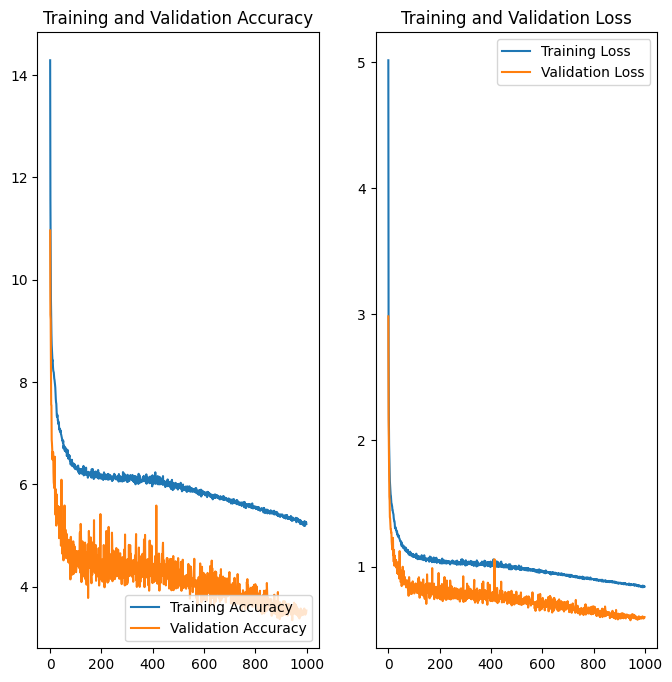

In [32]:
acc = history.history['desviacion_total']
val_acc = history.history['val_desviacion_total']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [42]:
test_loss, test_acc = model.evaluate(campvecval,coefcampvecval)

NameError: name 'campvecval' is not defined

# Guardamos los datos de Accuracy y Loss

In [33]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historyconvcampvec20.csv', index=False)

# Guardamos el modelo

In [34]:
path_to_save = '../../../Modelos/Modelos 20,50/'

In [35]:
model.save(path_to_save + '/convolucionalcv20.h5')

# Importamos el modelo

In [4]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [6]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def desviacion_total(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    return total_loss

metrics = [mse_component(i) for i in range(7)] + [desviacion_total]


In [9]:
custom_objects = {'custom_activation': custom_activation, 'desviacion_total': desviacion_total}

# Añade las métricas personalizadas
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)

# Si también utilizaste la métrica mean_metric, inclúyela
custom_objects['desviacion_total'] = desviacion_total

new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/convolucionalcv20.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [23]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[10, 2, 4, 2, 2, 10, 1]


In [24]:
campvecnone = campvec[None, :]
campvecnone = np.transpose(campvecnone, (0,2,3,1))

## Predecimos con los datos nuevos

In [25]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 11ms/step
[[ 9.  3.  4.  4.  2. 10.  1.]]


## Encontramos puntos de equilibrio datos reales

In [26]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(5.494560715201438, 0.43079500042733787)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

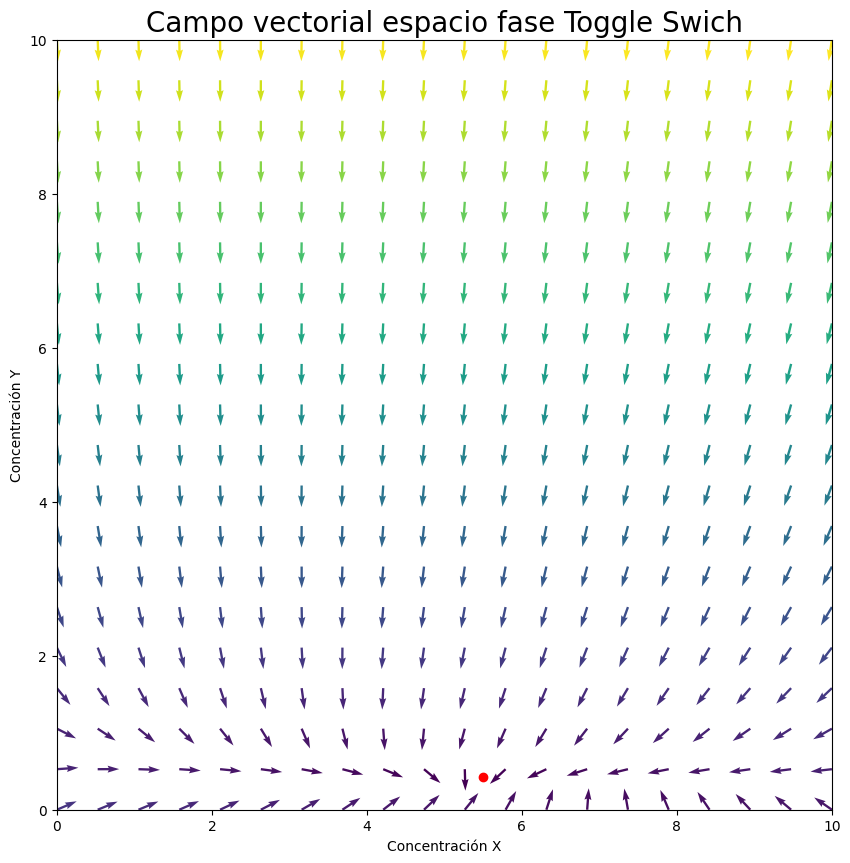

In [33]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [28]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(5.105295017039674, 0.4491376746186657)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

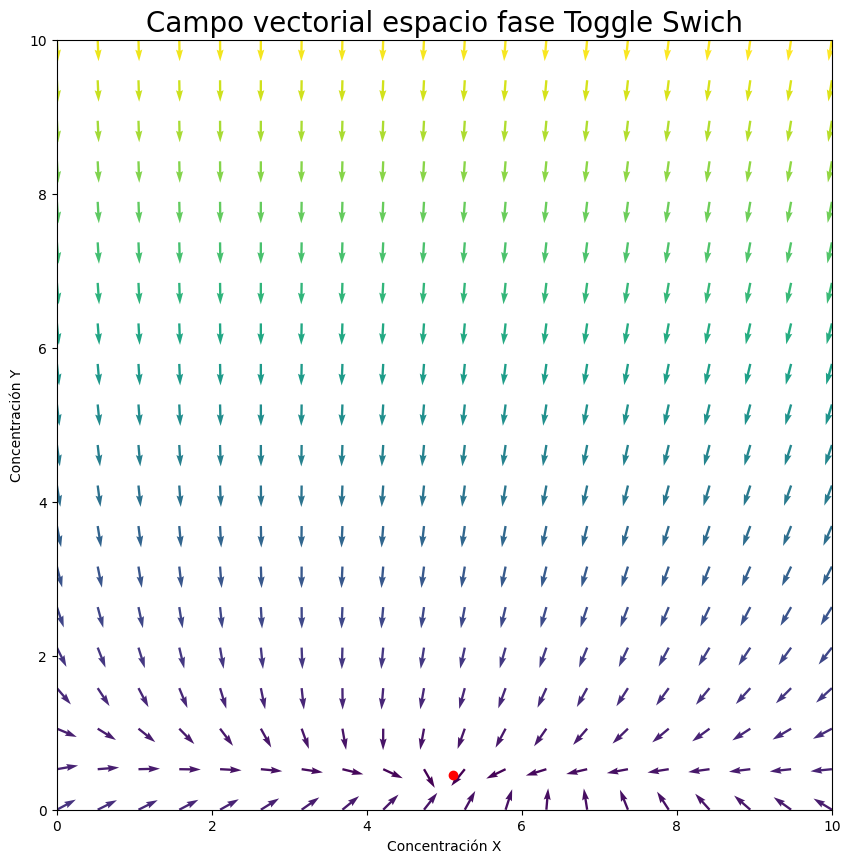

In [32]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 20)
y2pred = np.linspace(y_range_neg, y_range_pos, 20)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

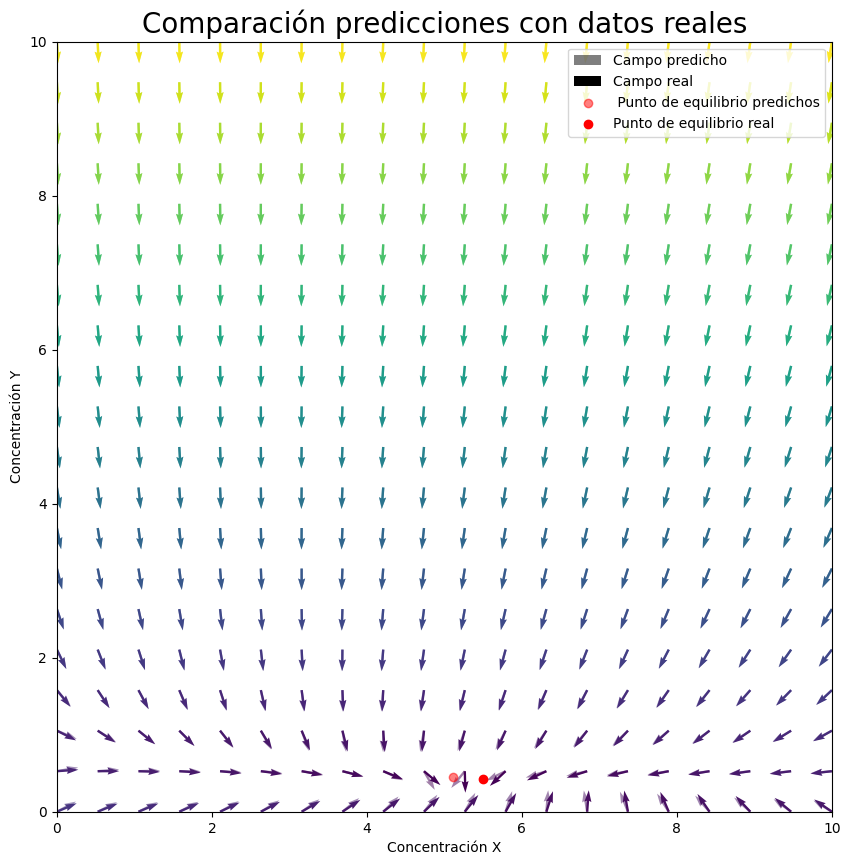

In [34]:
#%matplotlib qt
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5, label = "Campo predicho")

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1, label = "Campo real")

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5, label = " Punto de equilibrio predichos")
ax.scatter(x_values, y_values, color='red', alpha = 1, label = "Punto de equilibrio real")
ax.set_title('Comparación predicciones con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')
ax.legend(loc='upper right')  # Agregar leyenda a la gráfica
plt.show()

## Graficamos las diferencias

20.662298178016496


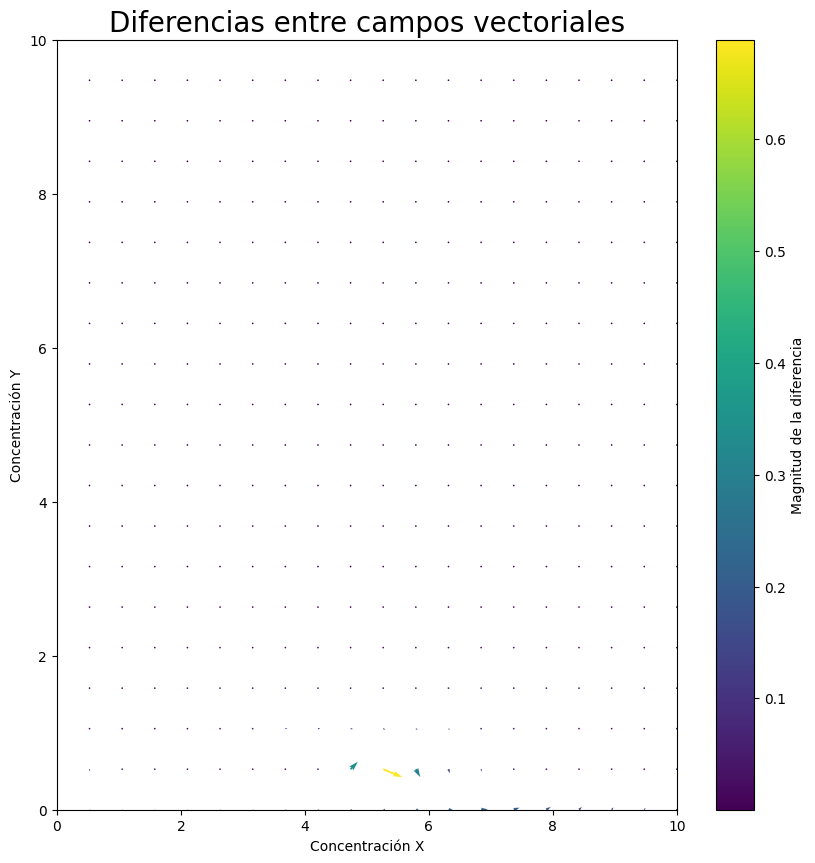

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos

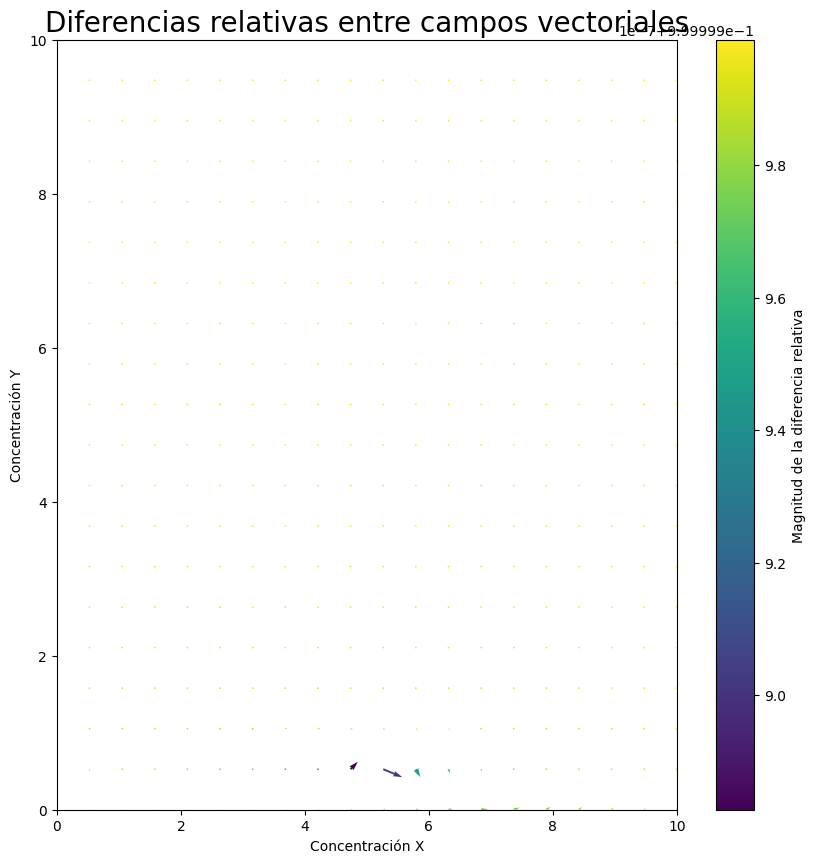

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [39]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 0.9999999989682604
El valor de u1 en el error relativo máximo es: -15.181818181818183
El valor de u1pred en el error relativo máximo es: -15.181818181818183
El valor de v1 en el error relativo máximo es: -95.72727272727273
El valor de v1pred en el error relativo máximo es: -95.72727272727273


In [40]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

1.0